In [1]:
!python --version

Python 3.10.0


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import image_dataset_from_directory
import shutil 
import pathlib
import tensorflow as tf
import sys 
from sklearn.metrics import r2_score, mean_squared_error
import pickle 
import seaborn as sns
import time
from keras import backend
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
from matplotlib.colors import LinearSegmentedColormap

# Definición de colores para las futuras gráficas

In [3]:
d_blue = '#000078'
l_blue = '#73EDFF'
green = '#38FF90'
yellow = '#FFE000'
red = '#FF7D87'
purple = '#BD9EFF'
pink = '#FF87FF'

s_l_blue = '#D6FAFF'
s_gree = '#C2FFDE'
s_yellow = '#FFF5B2'
s_red = '#FFD9DB'
s_purple = '#EBE3FF'
s_pink = '#FFDBFF'

l_gray = '#F0F0F0'
m_gray = '#D0D0D0'
d_gray = '#878787'

# Modelado

## Preprocesado

### Carga de los datos

In [4]:
# Crear un DataFrame para almacenar información del nombre del archivo
df = pd.read_csv("data_for_models.csv")
df.head()

,filename,time,irradiation,loss
0,solar_Tue_Jun_13_9__46__49_2017_L_0.0474843723...,35209,0.296733,0.047484
1,solar_Tue_Jun_13_9__46__54_2017_L_0.0273312333...,35214,0.288831,0.027331
2,solar_Tue_Jun_13_9__46__59_2017_L_0.0273312333...,35219,0.288831,0.027331
3,solar_Tue_Jun_13_9__47__4_2017_L_0.03979859380...,35224,0.300631,0.039799
4,solar_Tue_Jun_13_9__47__9_2017_L_0.03979859380...,35229,0.300631,0.039799


In [7]:
images_dir = '../TFM/Solar_Panel_Soiling_Image_dataset/PanelImages'

df_p = df.copy()
df_p['filename'] = df_p['filename'].apply(lambda x: os.path.join(images_dir, x))
df_p.head()

,filename,time,irradiation,loss
0,../TFM/Solar_Panel_Soiling_Image_dataset/Panel...,35209,0.296733,0.047484
1,../TFM/Solar_Panel_Soiling_Image_dataset/Panel...,35214,0.288831,0.027331
2,../TFM/Solar_Panel_Soiling_Image_dataset/Panel...,35219,0.288831,0.027331
3,../TFM/Solar_Panel_Soiling_Image_dataset/Panel...,35224,0.300631,0.039799
4,../TFM/Solar_Panel_Soiling_Image_dataset/Panel...,35229,0.300631,0.039799


### Normalización de los datos numéricos

In [26]:
# Escalado de variables
sc = StandardScaler()

time_in_seconds = df_p['time'].values.reshape(-1, 1)
time_in_seconds = sc.fit_transform(time_in_seconds)
df_p.loc[:,('time')] = time_in_seconds

irradiation = df_p['irradiation'].values.reshape(-1, 1)
irradiation = sc.fit_transform(irradiation)
df_p.loc[:,('irradiation')] = irradiation

In [27]:
df_p = df_p.sample(frac=1).reset_index(drop=True)
df_p.head()

,filename,time,irradiation,loss
0,../TFM/Solar_Panel_Soiling_Image_dataset/Panel...,-1.140635,0.186802,0.079699
1,../TFM/Solar_Panel_Soiling_Image_dataset/Panel...,-0.978875,1.279710,0.639650
2,../TFM/Solar_Panel_Soiling_Image_dataset/Panel...,0.833313,1.094997,0.643712
3,../TFM/Solar_Panel_Soiling_Image_dataset/Panel...,0.318672,1.441406,0.569255
4,../TFM/Solar_Panel_Soiling_Image_dataset/Panel...,-0.223997,-0.172675,0.087500


## División de los datos

In [28]:
X = df_p.loc[:,['filename', 'time', 'irradiation']]
y = np.array(df_p['loss'])

In [29]:
# Dividir los datos en train y test
train, test = train_test_split(df_p,
                               test_size=0.2,
                               random_state=2024)

# Dividir los datos en train y test
test, val = train_test_split(test,
                             test_size=0.5,
                             random_state=2024)

In [30]:
class MyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, input1, input2, labels, batch_size=64, augmentation=False):
        self.input1 = input1
        self.input2 = input2
        self.labels = labels.reshape(-1,1)
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.labels))
        self.augmentation = augmentation
        self.data_augmentation = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2),
            tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
            tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
            tf.keras.layers.experimental.preprocessing.RandomFlip("vertical")
        ])

    def __len__(self):
        return int(np.ceil(len(self.labels) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size

        # Load and preprocess input1 images
        batch_input1 = [self.load_and_preprocess_image(img_path) for img_path in self.input1[start:end]]
        batch_input1 = tf.stack(batch_input1, axis=0)
        
        batch_input2 = self.input2[start:end]
        batch_input2 = tf.convert_to_tensor(batch_input2, dtype=tf.float32)
        
        batch_labels = self.labels[start:end]
        batch_labels = tf.convert_to_tensor(batch_labels, dtype=tf.float32)

        return [batch_input1, batch_input2], batch_labels

    def load_and_preprocess_image(self, img):
        # Load the image from the file path
        img = cv2.imread(img)[:,:,::-1]
        
        # Rezize the image 
        img = cv2.resize(img, (224, 224))
        
        # Convert to a TensorFlow tensor
        img = tf.convert_to_tensor(img, dtype=tf.float32)

        if self.augmentation:
            img = data_augmentation(image)

        return img

In [31]:
batch_size = 128

# Datos de entrada
X_train_input1 = train['filename'].values # Datos para input1
X_train_input2 = train.loc[:, ['time', 'irradiation']]  # Datos para input2
y_train = np.array(train['loss'])

X_val_input1 = val['filename'].values  # Datos para input1
X_val_input2 = val.loc[:, ['time', 'irradiation']]  # Datos para input2
y_val = np.array(val['loss'])

X_test_input1 = test['filename'].values  # Datos para input1
X_test_input2 = test.loc[:, ['time', 'irradiation']]  # Datos para input2
y_test = np.array(test['loss'])

# Crear generador
train_data_generator = MyDataGenerator(X_train_input1, X_train_input2, y_train, batch_size)
val_data_generator = MyDataGenerator(X_val_input1, X_val_input2, y_val, batch_size)
test_data_generator = MyDataGenerator(X_test_input1, X_test_input2, y_test, 32)

## Funciones y diccionarios para el modelado

In [74]:
# Rutas de los registros y los modelos
dir_histories = '../TFM/histories'
dir_models = '../TFM/models'

# Lista de modelos
list_models = ['EfficientNetV2S', 'NASNetMobile', 'InceptionResNetV2',
              'ResNet50', 'MobileNetV2', 'ResNetRS50']

# Diccionario de rutas de los modelos y las historias
dict_paths = {}
for model in list_models:
    h = os.path.join(dir_histories, model + '.pkl')
    m = os.path.join(dir_models, model)

    dict_paths[model] = {'History': h, 'Model': m}

# Diccionario de modelos
models = {}

# Diccionario de registros
histories = {}

# Diccionario de modelos preentrenados
pretrained_models = {}
pretrained_models['EfficientNetV2S'] = tf.keras.applications.EfficientNetV2S
pretrained_models['NASNetMobile'] = tf.keras.applications.NASNetMobile
pretrained_models['InceptionResNetV2'] = tf.keras.applications.InceptionResNetV2
pretrained_models['ResNet50'] = tf.keras.applications.ResNet50
pretrained_models['MobileNetV2'] = tf.keras.applications.MobileNetV2
pretrained_models['ResNetRS50'] = tf.keras.applications.ResNetRS50

# Diccionario de preprocesado de la entrada a modelos preentrenados
preprocess_input = {}
preprocess_input['EfficientNetV2S'] = tf.keras.applications.efficientnet_v2.preprocess_input
preprocess_input['NASNetMobile'] = tf.keras.applications.nasnet.preprocess_input
preprocess_input['InceptionResNetV2'] = tf.keras.applications.inception_resnet_v2.preprocess_input
preprocess_input['ResNet50'] = tf.keras.applications.resnet50.preprocess_input
preprocess_input['MobileNetV2'] = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input['ResNetRS50'] = tf.keras.applications.resnet_rs.preprocess_input

In [75]:

def create_train_model(name):

    pretrained_model = pretrained_models[name](include_top=False,
                                               input_shape=(224,224,3),
                                               pooling='avg',
                                               weights='imagenet')
    
    for layer in pretrained_model.layers:
        layer.trainable=False
    
    # Definir las capas de entrada
    input1 = tf.keras.layers.Input(shape=(224,224,3), name='input1')
    input2 = tf.keras.layers.Input(shape=(2,), name='input2')
    
    # Red neuronal para la primera entrada
    preprocess = preprocess_input[name](input1)
    preTrained = pretrained_model(preprocess)
    output1 = tf.keras.layers.Dense(128, activation='relu')(preTrained)
    output1 = tf.keras.layers.Dense(64, activation='relu')(output1)
    
    # Red neuronal para la segunda entrada
    hidden2 = tf.keras.layers.Dense(128, activation='relu')(input2)
    output2 = tf.keras.layers.Dense(64, activation='relu')(hidden2) 
    
    
    # Concatenar las salidas de ambas redes
    merged = tf.keras.layers.Concatenate()([output1, output2])
    
    # Red neuronal final
    output3 = tf.keras.layers.Dense(32, activation='relu')(merged)
    final_output = tf.keras.layers.Dense(1, activation='linear')(output3)
    
    # Crear el modelo
    model = tf.keras.Model(inputs=[input1, input2], outputs=final_output)
    
    #model.summary()
    
    # Compilar el modelo
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse') 
    
    # Entrenar el modelo con tus datos
    start_train = time.time()
    history = model.fit(train_data_generator,
                        validation_data=val_data_generator,
                        epochs = 100,
                        callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True)],
                        workers=-1
    )
    end_train = time.time() - start_train
    minutes, seconds = divmod(end_train, 60)
    print('Tiempo de entrenamiento: {} min {} s'.format(minutes, round(seconds)))

    with open(dict_paths[name]['History'], 'wb') as file:
        pickle.dump(history.history, file)

    model.save(dict_paths[name]['Model'])

    show_metrics(history.history, name)

    return history.history

## Entrenamiento de los modelos

Epoch 1/100
286/286 [==============================] - 316s 1s/step - loss: 0.0244 - val_loss: 0.0113
Epoch 2/100
286/286 [==============================] - 155s 542ms/step - loss: 0.0125 - val_loss: 0.0100
Epoch 3/100
286/286 [==============================] - 165s 578ms/step - loss: 0.0109 - val_loss: 0.0094
Epoch 4/100
286/286 [==============================] - 151s 529ms/step - loss: 0.0102 - val_loss: 0.0097
Epoch 5/100
286/286 [==============================] - 151s 530ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 6/100
286/286 [==============================] - 152s 531ms/step - loss: 0.0095 - val_loss: 0.0091
Epoch 7/100
286/286 [==============================] - 150s 525ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 8/100
286/286 [==============================] - 150s 526ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 9/100
286/286 [==============================] - 151s 529ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 10/100
286/286 [==============================] - 15

INFO:tensorflow:Assets written to: ../TFM/models\EfficientNetV2S\assets


INFO:tensorflow:Assets written to: ../TFM/models\EfficientNetV2S\assets


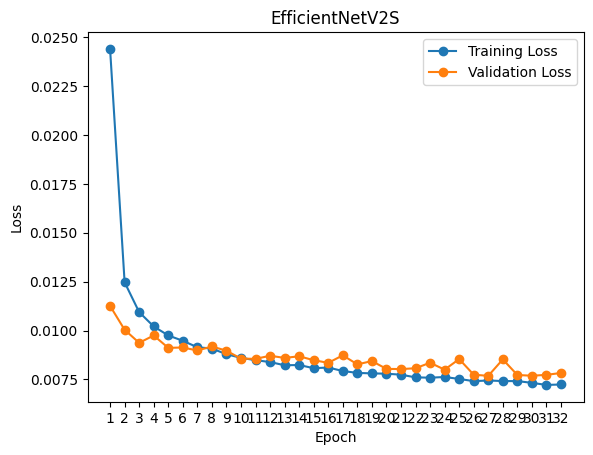

Epoch 1/100
286/286 [==============================] - 132s 424ms/step - loss: 0.0230 - val_loss: 0.0143
Epoch 2/100
286/286 [==============================] - 115s 403ms/step - loss: 0.0127 - val_loss: 0.0122
Epoch 3/100
286/286 [==============================] - 114s 399ms/step - loss: 0.0109 - val_loss: 0.0110
Epoch 4/100
286/286 [==============================] - 115s 404ms/step - loss: 0.0100 - val_loss: 0.0105
Epoch 5/100
286/286 [==============================] - 116s 405ms/step - loss: 0.0094 - val_loss: 0.0101
Epoch 6/100
286/286 [==============================] - 114s 398ms/step - loss: 0.0090 - val_loss: 0.0097
Epoch 7/100
286/286 [==============================] - 115s 403ms/step - loss: 0.0088 - val_loss: 0.0101
Epoch 8/100
286/286 [==============================] - 115s 403ms/step - loss: 0.0086 - val_loss: 0.0094
Epoch 9/100
286/286 [==============================] - 114s 400ms/step - loss: 0.0084 - val_loss: 0.0093
Epoch 10/100
286/286 [==============================] -

INFO:tensorflow:Assets written to: ../TFM/models\NASNetMobile\assets


INFO:tensorflow:Assets written to: ../TFM/models\NASNetMobile\assets


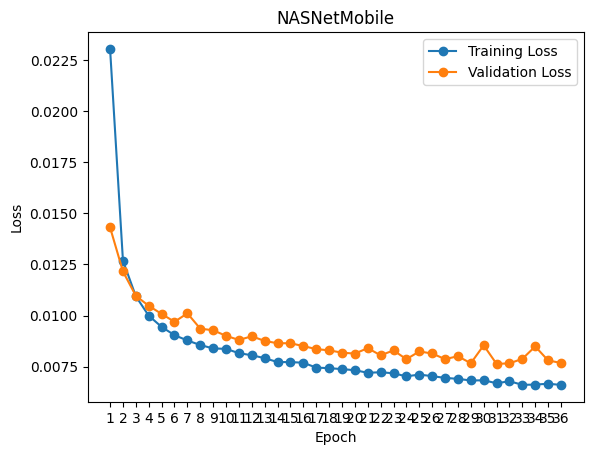

Epoch 1/100
286/286 [==============================] - 219s 739ms/step - loss: 0.0196 - val_loss: 0.0133
Epoch 2/100
286/286 [==============================] - 208s 726ms/step - loss: 0.0120 - val_loss: 0.0122
Epoch 3/100
286/286 [==============================] - 207s 723ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 4/100
286/286 [==============================] - 208s 728ms/step - loss: 0.0097 - val_loss: 0.0097
Epoch 5/100
286/286 [==============================] - 208s 726ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 6/100
286/286 [==============================] - 208s 726ms/step - loss: 0.0090 - val_loss: 0.0104
Epoch 7/100
286/286 [==============================] - 206s 720ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 8/100
286/286 [==============================] - 208s 727ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 9/100
286/286 [==============================] - 209s 730ms/step - loss: 0.0085 - val_loss: 0.0088
Epoch 10/100
286/286 [==============================] -

INFO:tensorflow:Assets written to: ../TFM/models\InceptionResNetV2\assets


INFO:tensorflow:Assets written to: ../TFM/models\InceptionResNetV2\assets


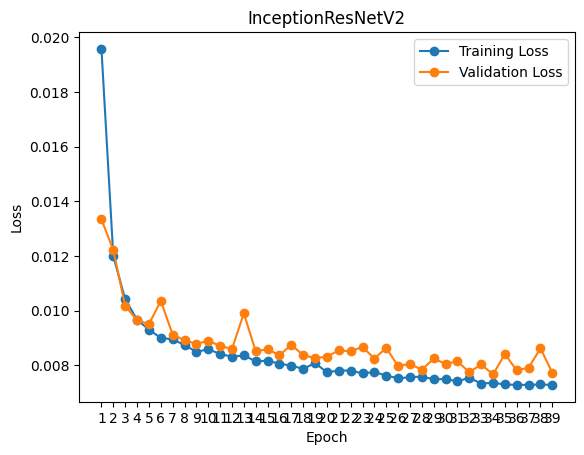

Epoch 1/100
286/286 [==============================] - 178s 612ms/step - loss: 0.0159 - val_loss: 0.0116
Epoch 2/100
286/286 [==============================] - 173s 605ms/step - loss: 0.0097 - val_loss: 0.0099
Epoch 3/100
286/286 [==============================] - 174s 609ms/step - loss: 0.0089 - val_loss: 0.0095
Epoch 4/100
286/286 [==============================] - 172s 603ms/step - loss: 0.0084 - val_loss: 0.0093
Epoch 5/100
286/286 [==============================] - 174s 608ms/step - loss: 0.0080 - val_loss: 0.0092
Epoch 6/100
286/286 [==============================] - 173s 607ms/step - loss: 0.0079 - val_loss: 0.0086
Epoch 7/100
286/286 [==============================] - 172s 603ms/step - loss: 0.0075 - val_loss: 0.0082
Epoch 8/100
286/286 [==============================] - 172s 603ms/step - loss: 0.0074 - val_loss: 0.0088
Epoch 9/100
286/286 [==============================] - 174s 609ms/step - loss: 0.0072 - val_loss: 0.0083
Epoch 10/100
286/286 [==============================] -

INFO:tensorflow:Assets written to: ../TFM/models\ResNet50\assets


INFO:tensorflow:Assets written to: ../TFM/models\ResNet50\assets


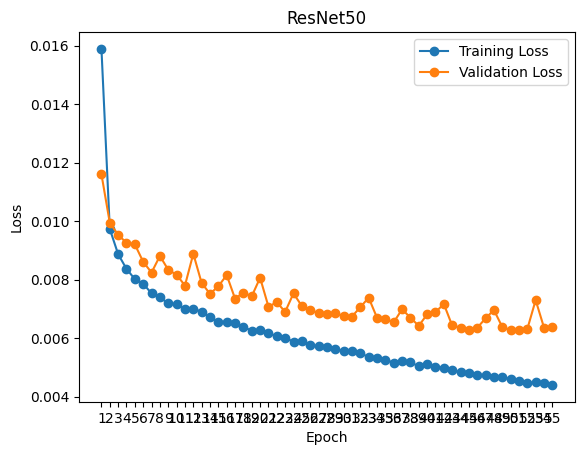

Epoch 1/100
286/286 [==============================] - 119s 408ms/step - loss: 0.0437 - val_loss: 0.0131
Epoch 2/100
286/286 [==============================] - 115s 401ms/step - loss: 0.0116 - val_loss: 0.0114
Epoch 3/100
286/286 [==============================] - 117s 410ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 4/100
286/286 [==============================] - 114s 400ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 5/100
286/286 [==============================] - 115s 401ms/step - loss: 0.0088 - val_loss: 0.0092
Epoch 6/100
286/286 [==============================] - 116s 407ms/step - loss: 0.0084 - val_loss: 0.0088
Epoch 7/100
286/286 [==============================] - 115s 401ms/step - loss: 0.0082 - val_loss: 0.0086
Epoch 8/100
286/286 [==============================] - 115s 401ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 9/100
286/286 [==============================] - 118s 412ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 10/100
286/286 [==============================] -

INFO:tensorflow:Assets written to: ../TFM/models\MobileNetV2\assets


INFO:tensorflow:Assets written to: ../TFM/models\MobileNetV2\assets


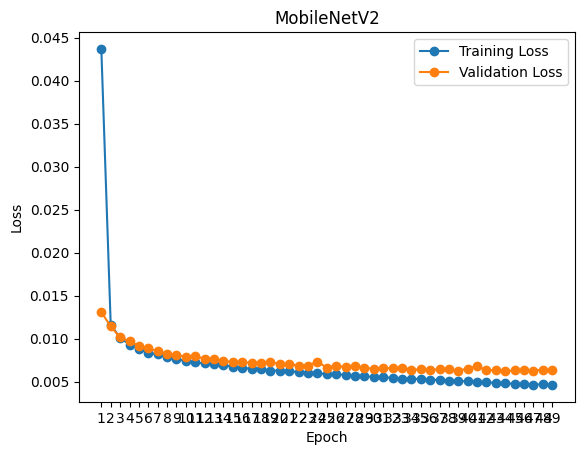

Epoch 1/100
286/286 [==============================] - 176s 600ms/step - loss: 0.0164 - val_loss: 0.0118
Epoch 2/100
286/286 [==============================] - 169s 591ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 3/100
286/286 [==============================] - 172s 600ms/step - loss: 0.0092 - val_loss: 0.0102
Epoch 4/100
286/286 [==============================] - 170s 595ms/step - loss: 0.0085 - val_loss: 0.0097
Epoch 5/100
286/286 [==============================] - 169s 593ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 6/100
286/286 [==============================] - 170s 593ms/step - loss: 0.0077 - val_loss: 0.0085
Epoch 7/100
286/286 [==============================] - 169s 590ms/step - loss: 0.0074 - val_loss: 0.0084
Epoch 8/100
286/286 [==============================] - 170s 594ms/step - loss: 0.0072 - val_loss: 0.0082
Epoch 9/100
286/286 [==============================] - 170s 594ms/step - loss: 0.0069 - val_loss: 0.0090
Epoch 10/100
286/286 [==============================] -

INFO:tensorflow:Assets written to: ../TFM/models\ResNetRS50\assets


INFO:tensorflow:Assets written to: ../TFM/models\ResNetRS50\assets


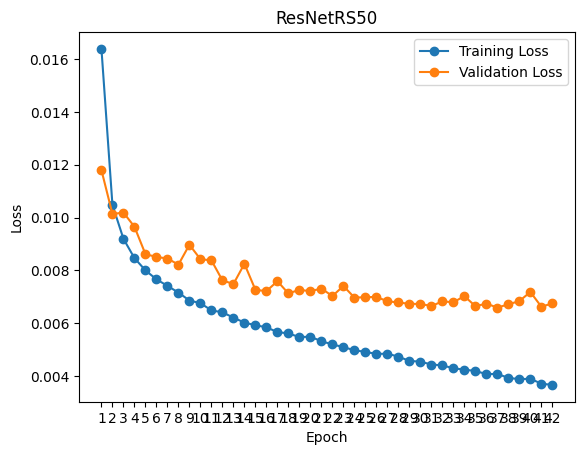

In [37]:
# Crear, entrenar y guardar los modelos
for name in list_models:
    histories[name] = create_train_model(name)

In [77]:
table_time_epochs = {'EfficientNetV2S': {'Time': '83 min 33 s', 'Epochs':32},
                     'NASNetMobile': {'Time':'69 min 11 s','Epochs':36},
                     'InceptionResNetV2': {'Time':'134 min 59 s','Epochs':39},
                     'ResNet50': {'Time':'159 min 24 s','Epochs':55},
                     'MobileNetV2': {'Time':'94 min 22 s','Epochs':49},
                     'ResNetRS50': {'Time':'119 min 18 s','Epochs':42}}
table_time_epochs

{'EfficientNetV2S': {'Time': '83 min 33 s', 'Epochs': 32},
 'NASNetMobile': {'Time': '69 min 11 s', 'Epochs': 36},
 'InceptionResNetV2': {'Time': '134 min 59 s', 'Epochs': 39},
 'ResNet50': {'Time': '159 min 24 s', 'Epochs': 55},
 'MobileNetV2': {'Time': '94 min 22 s', 'Epochs': 49},
 'ResNetRS50': {'Time': '119 min 18 s', 'Epochs': 42}}

### Funciones para analizar los modelos

In [78]:
def show_metrics(history, name):   
    train_loss = history['loss']
    val_loss = history['val_loss']
    
    # Visualizar la pérdida de entrenamiento y validación
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.title(name)
    plt.show()
    len(train_loss)

In [79]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "B":
        return('File size: ' + str(size) + ' bytes')
    if unit == "KB":
        return('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    if unit == "MB":
        return('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    if unit == "GB":
        return('File size: ' + str(round(size / (1024 * 1024 * 1024), 3)) + ' Megabytes')

def get_foulder_size(foulder_path):
    total_size = 0

    for dirpath, dirnames, filenames in os.walk(foulder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += get_file_size(file_path)

    return total_size

In [80]:
def advanced_analisis_model(model_path, test):
    model = tf.keras.models.load_model(model_path)
    
    start_time = time.time()
    predicted_loss = np.squeeze(model.predict(test))
    total_time = time.time() - start_time

    # Liberar memoria de la GPU
    backend.clear_session()
    
    time_list = []
    for i in range(10):
        input1 = tf.expand_dims(test.__getitem__(0)[0][0][i], axis=0)
        input2 = tf.expand_dims(test.__getitem__(0)[0][1][i], axis=0)
        
        start_time_2 = time.time()
        one_prediction = np.squeeze(model.predict([input1, input2]))
        total_time_2 = time.time() - start_time_2
        if i > 0:
            time_list.append(total_time_2)
    total_time_2 = np.mean(time_list)
     
    
    true_loss = test.labels
    
    mse = model.evaluate(test, verbose=0)
    print("Test MSE {:.5f}".format(mse))
    
    rmse = np.sqrt(mean_squared_error(true_loss, predicted_loss))
    print("Test RMSE {:.5f}".format(rmse))
    
    r2 = r2_score(true_loss, predicted_loss)
    print('Test R^2 Score: {:.5f}'.format(r2))
    
    print('Tiempo de test: {:.3f} s'.format(total_time))
    print('Tiempo de una sola predicción: {:.3f} s'.format(total_time_2))

    model_size = get_foulder_size(model_path)
    print(convert_bytes(model_size, "MB"))

    return total_time, total_time_2, mse, rmse, r2, model_size

### Resultados de los modelos originales

In [91]:
analysis_data = {}

for name in list_models:
    print('####### ', name, ' #######')
    analysis_data[name] = advanced_analisis_model(dict_paths[name]['Model'], test_data_generator)
    print('\n')

#######  EfficientNetV2S  #######
1/1 [==============================] - 0s 41ms/step
Test MSE 0.00719
Test RMSE 0.08481
Test R^2 Score: 0.91070
Tiempo de test: 33.824 s
Tiempo de una sola predicción: 0.103 s
File size: 93.108 Megabytes


#######  NASNetMobile  #######
1/1 [==============================] - 0s 41ms/step
Test MSE 0.00689
Test RMSE 0.08300
Test R^2 Score: 0.91447
Tiempo de test: 28.223 s
Tiempo de una sola predicción: 0.097 s
File size: 36.806 Megabytes


#######  InceptionResNetV2  #######
1/1 [==============================] - 0s 48ms/step
Test MSE 0.00759
Test RMSE 0.08712
Test R^2 Score: 0.90576
Tiempo de test: 39.588 s
Tiempo de una sola predicción: 0.167 s
File size: 225.935 Megabytes


#######  ResNet50  #######
1/1 [==============================] - 0s 28ms/step
Test MSE 0.00494
Test RMSE 0.07027
Test R^2 Score: 0.93869
Tiempo de test: 25.901 s
Tiempo de una sola predicción: 0.069 s
File size: 97.554 Megabytes


#######  MobileNetV2  #######
1/1 [================

In [ ]:
with open('../TFM/original_test.pkl', 'wb') as file:
    pickle.dump(analysis_data, file)

In [100]:
analysis_data = {
    'EfficientNetV2S': [20.875, 0.080, 0.00742, 0.08613, 0.90735, 93.108],
    'NASNetMobile': [16.077, 0.090, 0.00748, 0.08648, 0.90661, 36.806],
    'InceptionResNetV2': [25.662, 0.137, 0.00770, 0.08774, 0.90386, 225.935],
    'ResNet50': [17.407, 0.063, 0.00660, 0.08124, 0.91757, 97.554],
    'MobileNetV2': [12.582, 0.060, 0.00701, 0.08371, 0.91249, 14.658],
    'ResNetRS50': [19.982, 0.066, 0.00664, 0.08150, 0.91706, 138.112]
}

#### Gráficas de resultados

In [101]:
num_models = len(list_models)

dict_metrics = {'Time Test': [], 'Time Prediction': [],
                'MSE': [], 'RMSE': [], 'R2 Score': [],
               'Model Size': []}

list_metrics = dict_metrics.keys()

for i, k in enumerate(dict_metrics.keys()): 
    for model_name in list_models:
        dict_metrics[k].append(analysis_data[model_name][i])

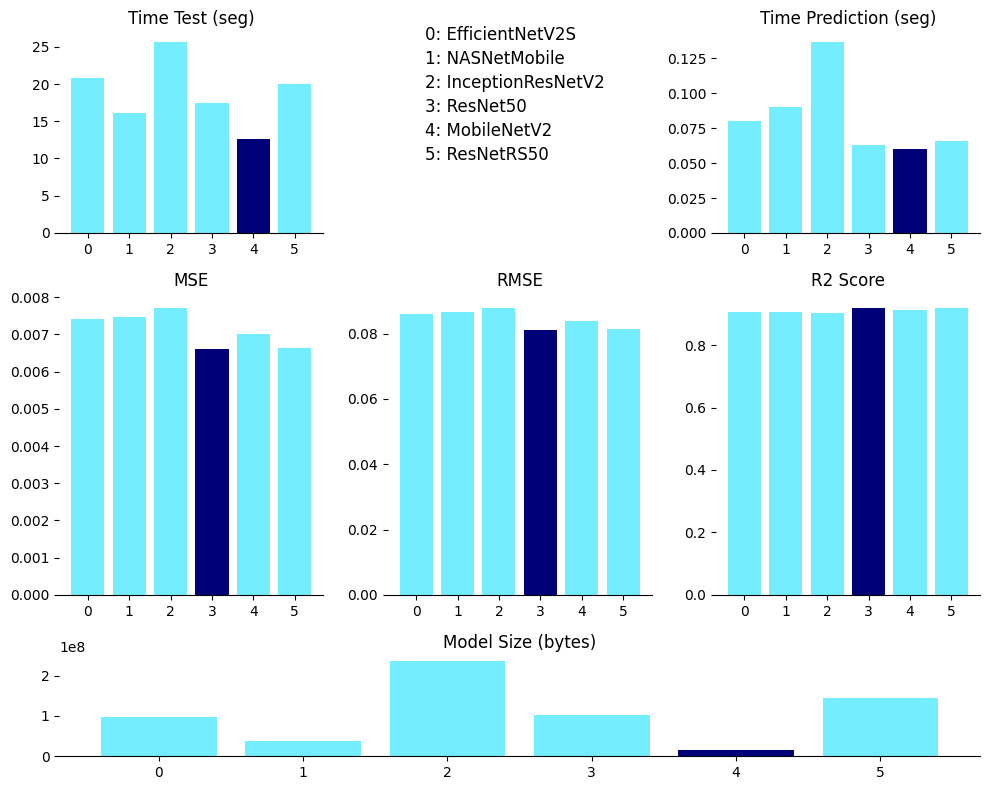

In [96]:

graph_struct = [{'r': 0, 'c':0},
               {'r': 0, 'c':2},
               {'r': 1, 'c':0},
               {'r': 1, 'c':1},
               {'r': 1, 'c':2},
               {'r': 2, 'c':':'}]

# Crear la figura y los subplots con gridspec
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1], height_ratios=[2, 3, 1])

for i, (k, v) in enumerate(dict_metrics.items()):
    
    bars_colors = [l_blue for _ in range(len(v))]
    
    max_index = v.index(np.max(v))
    min_index = v.index(np.min(v))

    if k != 'R2 Score':
        bars_colors[min_index] = d_blue
    else:
        bars_colors[max_index] = d_blue
    
        
    title = k
    if (k == 'Time Test') or (k == 'Time Prediction'):
        title += ' (seg)'  
    if k == 'Model Size':
        title += ' (bytes)'
        
    r = graph_struct[i]['r']
    c = graph_struct[i]['c']
    
    if r != 2:
        ax = plt.subplot(gs[r, c])
    else:
        ax = plt.subplot(gs[r, :])
        
    plt.bar(range(num_models), v, color=bars_colors)
    ax.set_title(title)
    ax.set_xticks(range(num_models))
    hide_frames(ax)

height = 0.95
for idx, model in enumerate(list_models):
    fig.text(0.43, height, str(idx) + ': ' + model, ha='left', va='center', fontsize=12, color='black')
    height -= 0.03

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()

# Mostrar las gráficas
plt.show()

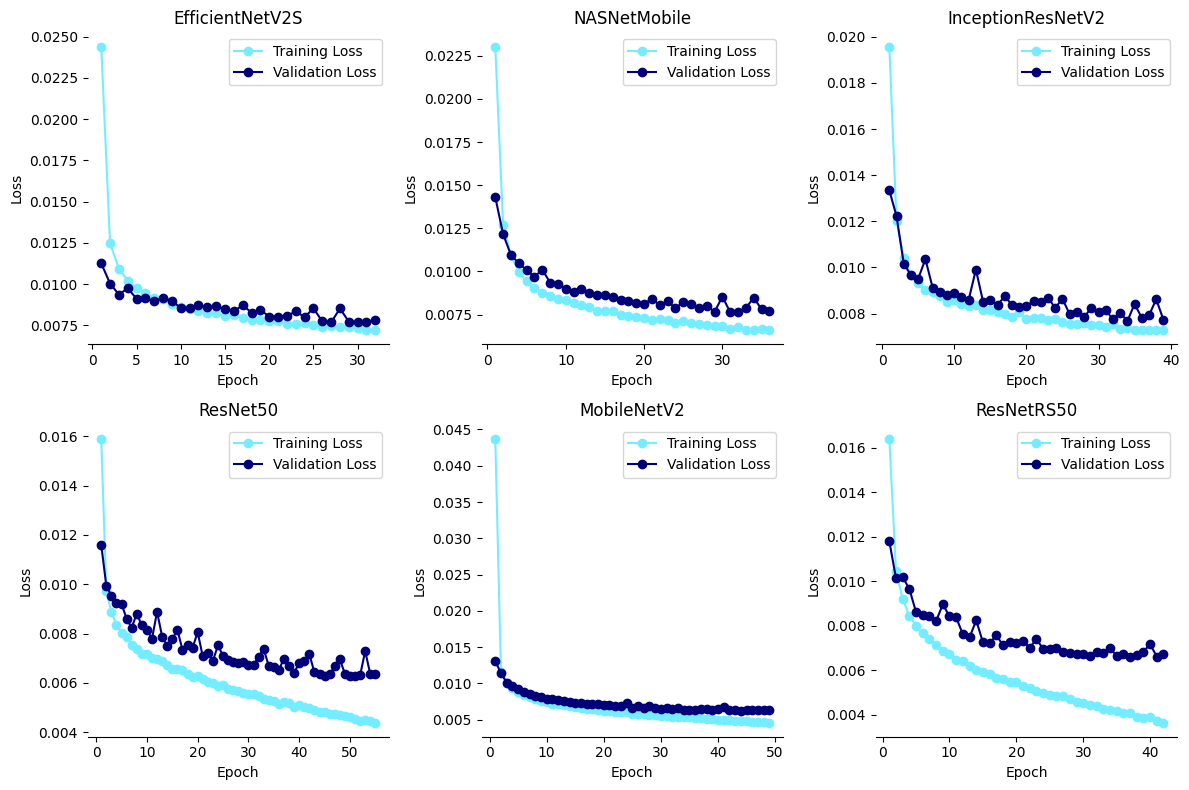

In [97]:
# Crear una figura y subgráficos
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

n = 0
for row in range(2):
    for col in range(3):
        name = list_models[n]
        with open(dict_paths[name]['History'], 'rb') as file:
            loaded_history = pickle.load(file)
            
        loss = loaded_history['loss']
        val_loss = loaded_history['val_loss']
        
        # Visualizar la pérdida de entrenamiento y validación
        epochs = range(1, len(loss) + 1)
        axs[row, col].plot(epochs, loss, label='Training Loss', marker='o', color=l_blue)
        axs[row, col].plot(epochs, val_loss, label='Validation Loss', marker='o', color=d_blue)
        axs[row, col].set_xlabel('Epoch')
        axs[row, col].set_ylabel('Loss')
        #axs[row, col].set_xticks(epochs)
        axs[row, col].legend()
        axs[row, col].set_title(name)

        hide_frames(axs[row, col])

        n += 1
        

plt.tight_layout()
plt.show()     

#### Creación y anális de los modelos LITE

In [98]:
dict_lite_models = {}
dict_lite_paths = {}
dir_lite = '../TFM/lite_models'

for model in list_models:
    path = os.path.join(dir_lite, model + '.tflite')
    dict_lite_paths[model] = path

### Funciones para crear los modelos Lite y analizarlos

In [164]:

def convert_to_lite(modelName, modelPath, litePath):
    
    # Crear un convertidor TFLite
    converter = tf.lite.TFLiteConverter.from_saved_model(modelPath)
    
    # Convertir el modelo a formato TFLite
    model_lite = converter.convert()
    
    # Guardar el modelo convertido en un archivo .tflite
    with open(litePath, 'wb') as f:
        f.write(model_lite)

    # Imprimir información sobre el modelo TFLite
    print(f"Modelo {modelName} convertido a Lite.")

In [326]:
def lite_models_analysis(nameModel, test):
    
    print('######', nameModel, '######')
    # Cargar el modelo TFLite
    interpreter = tf.lite.Interpreter(model_path=dict_lite_paths[nameModel])
    interpreter.allocate_tensors()
    
    # Obtener detalles de la entrada y salida del modelo
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Obtener dimensiones de las entradas
    input_shape1 = input_details[0]['shape']
    input_shape2 = input_details[1]['shape']

    predicted_loss = []
    true_loss = []

    for batch in test:

        for idx in range(len(batch[0][0])):
            
            input1 = np.array(batch[0][0][idx], dtype=np.float32).reshape(input_shape1)
            input2 = np.array(batch[0][1][idx], dtype=np.float32).reshape(input_shape2)

            #print("Entradas para TFLite:", input1.shape, input2.shape)

            time_start = time.time()
            
            # Cargar datos de entrada al modelo
            interpreter.set_tensor(input_details[0]['index'], input1)
            interpreter.set_tensor(input_details[1]['index'], input2)
            
            # Realizar la inferencia
            interpreter.invoke()
            
            # Obtener los resultados de la inferencia
            predicted_loss.append(np.squeeze(interpreter.get_tensor(
                output_details[0]['index']).item()))
    
            total_time = time.time() - time_start

            #print("Salidas de TFLite:", np.squeeze(interpreter.get_tensor(output_details[0]['index'])))
    
    true_loss = test.labels.flatten()
    
    mse = mean_squared_error(true_loss, predicted_loss)
    print("Test MSE {:.5f}".format(mse))
    
    rmse = np.sqrt(mean_squared_error(true_loss, predicted_loss))
    print("Test RMSE {:.5f}".format(rmse))
    
    r2 = r2_score(true_loss, predicted_loss)
    print('Test R^2 Score: {:.5f}'.format(r2))

    mean_time = np.mean(total_time)
    print('Promedio de tiempo de una sola predicción: {:.6f} ms'.format(mean_time*1000))

    model_size = os.path.getsize(dict_lite_paths[nameModel])
    print(convert_bytes(model_size, "MB"))
    
    print('\n')

    return mean_time, mse, rmse, r2, model_size, predicted_loss

In [165]:
for model in list_models:
    convert_to_lite(model, 
                    dict_paths[model]['Model'],
                    dict_lite_paths[model])

Modelo EfficientNetV2S convertido a Lite.
Modelo NASNetMobile convertido a Lite.
Modelo InceptionResNetV2 convertido a Lite.
Modelo ResNet50 convertido a Lite.
Modelo MobileNetV2 convertido a Lite.
Modelo ResNetRS50 convertido a Lite.


## Crear modelos Lite

In [330]:
mobilete = lite_models_analysis('MobileNetV2', test_data_generator)

###### MobileNetV2 ######
Test MSE 0.00701
Test RMSE 0.08370
Test R^2 Score: 0.91251
Promedio de tiempo de una sola predicción: 15.623808 ms
File size: 9.163 Megabytes




## Análisis de los modelos Lite

In [327]:
lite_analysis_data = {}

for name in list_models:      
    lite_analysis_data[name] = lite_models_analysis(name, test_data_generator)

###### EfficientNetV2S ######
Test MSE 0.00742
Test RMSE 0.08613
Test R^2 Score: 0.90735
Promedio de tiempo de una sola predicción: 156.247616 ms
File size: 77.559 Megabytes


###### NASNetMobile ######
Test MSE 0.00748
Test RMSE 0.08646
Test R^2 Score: 0.90665
Promedio de tiempo de una sola predicción: 46.864510 ms
File size: 16.894 Megabytes


###### InceptionResNetV2 ######
Test MSE 0.00770
Test RMSE 0.08775
Test R^2 Score: 0.90385
Promedio de tiempo de una sola predicción: 187.458992 ms
File size: 208.051 Megabytes


###### ResNet50 ######
Test MSE 0.00660
Test RMSE 0.08124
Test R^2 Score: 0.91759
Promedio de tiempo de una sola predicción: 124.979496 ms
File size: 90.695 Megabytes


###### MobileNetV2 ######
Test MSE 0.00701
Test RMSE 0.08370
Test R^2 Score: 0.91251
Promedio de tiempo de una sola predicción: 0.000000 ms
File size: 9.163 Megabytes


###### ResNetRS50 ######
Test MSE 0.00664
Test RMSE 0.08150
Test R^2 Score: 0.91706
Promedio de tiempo de una sola predicción: 124.9699

In [119]:
lite_analysis_data = {
    'EfficientNetV2S': [156.247616, 0.00742, 0.08613, 0.90735, 77.559],
    'NASNetMobile': [46.864510, 0.00748, 0.08646, 0.90665, 16.894],
    'InceptionResNetV2': [187.458992, 0.00770, 0.08775, 0.90385, 208.051],
    'ResNet50': [124.979496, 0.00660, 0.08124, 0.91759, 90.695],
    'MobileNetV2': [15.623808, 0.00701, 0.08370, 0.91251, 9.163],
    'ResNetRS50': [124.969959, 0.00664, 0.08150, 0.91706, 129.404]
}

In [120]:
dict_metrics_lite = {'Time Prediction': [],
                     'MSE': [], 'RMSE': [], 'R2 Score': [],
                     'Model Size': []}

list_metrics_lite = dict_metrics_lite.keys()

for i, k in enumerate(dict_metrics_lite.keys()): 
    for model_name in list_models:
        dict_metrics_lite[k].append(lite_analysis_data[model_name][i])

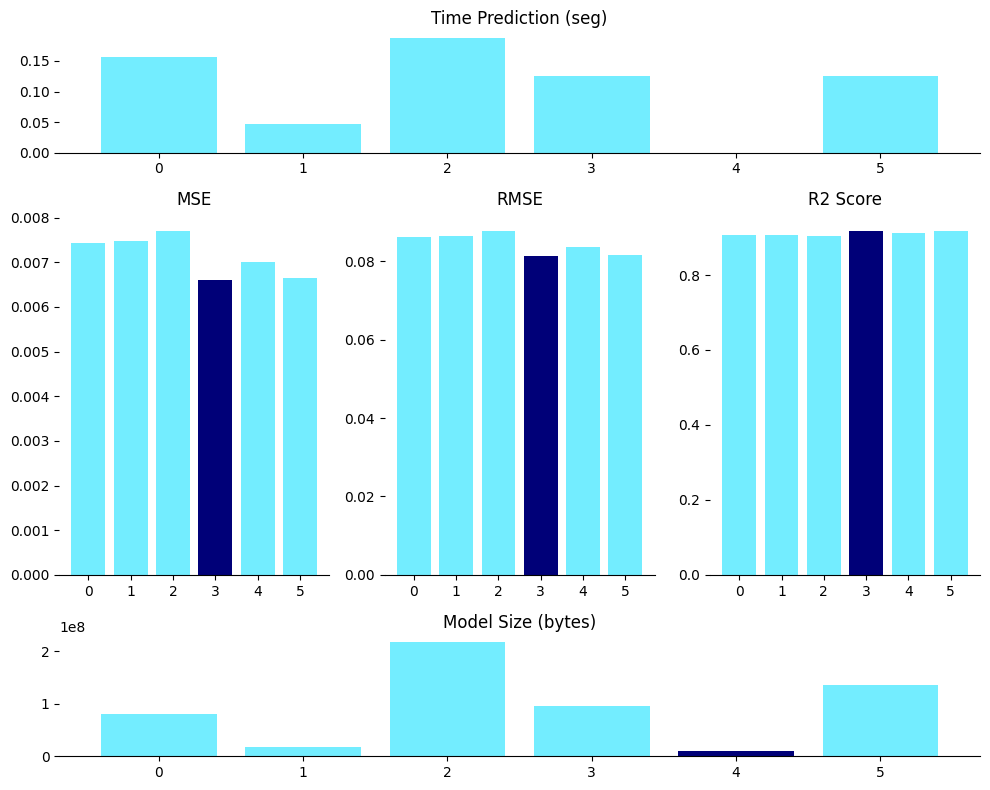

In [329]:
graph_struct = [{'r': 0, 'c':':'},
               {'r': 1, 'c':0},
               {'r': 1, 'c':1},
               {'r': 1, 'c':2},
               {'r': 2, 'c':':'}]

# Crear la figura y los subplots con gridspec
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1], height_ratios=[1, 3, 1])

for i, (k, v) in enumerate(dict_metrics_lite.items()):
    
    bars_colors = [l_blue for _ in range(len(v))]
    
    max_index = v.index(np.max(v))
    min_index = v.index(np.min(v))

    if k != 'R2 Score':
        bars_colors[min_index] = d_blue
    else:
        bars_colors[max_index] = d_blue
    
        
    title = k
    if (k == 'Time Test') or (k == 'Time Prediction'):
        title += ' (seg)'  
    if k == 'Model Size':
        title += ' (bytes)'
        
    r = graph_struct[i]['r']
    c = graph_struct[i]['c']
    
    if r in (0, 2):
        ax = plt.subplot(gs[r, :])
    else:
        ax = plt.subplot(gs[r, c])
        
        
    plt.bar(range(num_models), v, color=bars_colors)
    ax.set_title(title)
    ax.set_xticks(range(num_models))
    hide_frames(ax)

height = 0.95

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()

# Mostrar las gráficas
plt.show()

# Comparación Original vs Lite

In [ ]:
dict_comparation = {}

for model_name in list_models:

    original = []
    o_t_mse = lite_analysis_data[model_name][1]
    original.append(o_t_mse)
    o_mse   = lite_analysis_data[model_name][2]
    original.append(o_mse)
    o_rmse  = lite_analysis_data[model_name][3]
    original.append(o_rmse)
    o_r2    = lite_analysis_data[model_name][4]
    original.append(o_r2)
    o_size  = lite_analysis_data[model_name][5]
    original.append(o_size)
    
    lite = []
    lite_t_mse = lite_analysis_data[model_name][0]
    lite.append(lite_t_mse)
    lite_mse   = lite_analysis_data[model_name][1]
    lite.append(lite_mse)
    lite_rmse  = lite_analysis_data[model_name][2]
    lite.append(lite_rmse)
    lite_r2    = lite_analysis_data[model_name][3]
    lite.append(lite_r2)
    lite_size  = lite_analysis_data[model_name][4]
    lite.append(o_size)
    
    dict_comparation[model_name] = [original, lite]

In [138]:
dict_comparation = {'Time Prediction': [],
                    'MSE': [], 'RMSE': [], 'R2 Score': [],
                    'Model Size': []}

list_metrics_lite = dict_metrics_lite.keys()

for i, k in enumerate(dict_metrics_lite.keys()): 
    original = []
    lite = []
    for model_name in list_models:
        original.append(analysis_data[model_name][i+1])
        lite.append(lite_analysis_data[model_name][i])
    dict_comparation[k] = [original, lite]

In [155]:
dict_comparation['Time Prediction'][0] = [t*1000 for t in dict_comparation['Time Prediction'][0]]

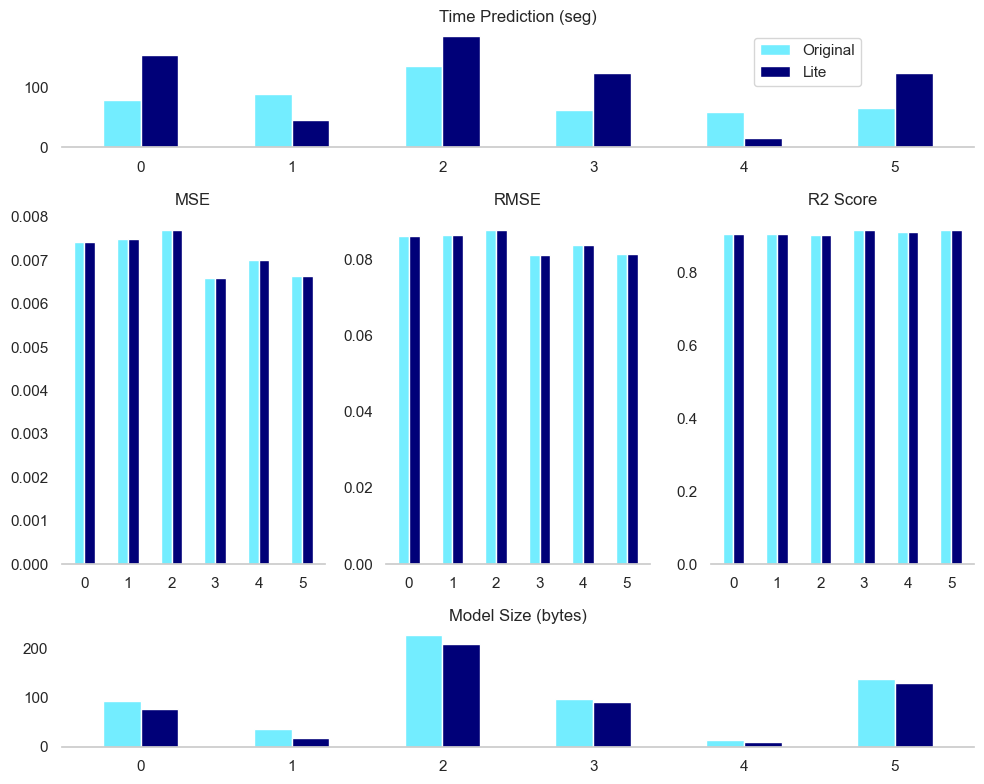

In [170]:
graph_struct = [{'r': 0, 'c':':'},
               {'r': 1, 'c':0},
               {'r': 1, 'c':1},
               {'r': 1, 'c':2},
               {'r': 2, 'c':':'}]



# Crear la figura y los subplots con gridspec
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1], height_ratios=[1, 3, 1])

for i, (k, v) in enumerate(dict_comparation.items()):
    
    bars_colors = [l_blue for _ in range(len(v[0]))]
        
    title = k
    if (k == 'Time Test') or (k == 'Time Prediction'):
        title += ' (seg)'  
    if k == 'Model Size':
        title += ' (bytes)'
        
    r = graph_struct[i]['r']
    c = graph_struct[i]['c']
    
    if r in (0, 2):
        ax = plt.subplot(gs[r, :])
    else:
        ax = plt.subplot(gs[r, c])
        
    width = 0.25   
    n = len(v[0])
    x = np.arange(n)
    
    plt.bar(x - width, v[0], width=width, label='Original', color=l_blue)
    plt.bar(x, v[1], width=width, label='Lite', color=d_blue)
    ax.set_title(title)
    ax.set_xticks(x - width/2)
    ax.set_xticklabels(['0', '1', '2', '3', '4', '5'])
    ax.grid(False)
    hide_frames(ax)

    if k == 'Time Prediction':
        ax.legend(loc='upper left', bbox_to_anchor=(0.75, 1.0))

height = 0.95

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()

# Mostrar las gráficas
plt.show()

# Resultados en RaspBerry Pi 4

In [245]:
with open('../TFM/models_return_raspberry.pkl', 'rb') as file:
    raspberry = pickle.load(file)

In [256]:
raspberry

{'EfficientNetV2S': {'Mean Time': 1.1202397825939407,
  'MSE': 0.007418720835959128,
  'RMSE': 0.08613199658639713,
  'R^2 score': 0.9073544418333737},
 'NASNetMobile': {'Mean Time': 0.33430267808215863,
  'MSE': 0.007475515479479145,
  'RMSE': 0.08646106337235938,
  'R^2 score': 0.9066451859432906},
 'InceptionResNetV2': {'Mean Time': 2.2054763434363194,
  'MSE': 0.007699201314641421,
  'RMSE': 0.08774509282370964,
  'R^2 score': 0.9038517799760342},
 'ResNet50': {'Mean Time': 1.272802107138712,
  'MSE': 0.006599321478776373,
  'RMSE': 0.08123620792957026,
  'R^2 score': 0.9175871642239524},
 'MobileNetV2': {'Mean Time': 0.17444790136618693,
  'MSE': 0.007006098682237159,
  'RMSE': 0.08370244131587297,
  'R^2 score': 0.9125072991235679},
 'ResNetRS50': {'Mean Time': 1.5134395582688962,
  'MSE': 0.006641895541504187,
  'RMSE': 0.08149782537898902,
  'R^2 score': 0.9170554960439447}}

In [255]:
rasberry_returns = {'Mean Time': [],
                    'MSE': [],
                    'RMSE': [],
                    'R^2 score': []}
for values in raspberry.values():
    rasberry_returns['Mean Time'].append(values['Mean Time'])
    rasberry_returns['MSE'].append(values['MSE'])
    rasberry_returns['RMSE'].append(values['RMSE'])
    rasberry_returns['R^2 score'].append(values['R^2 score'])

rasberry_returns

{'Mean Time': [1.1202397825939407,
  0.33430267808215863,
  2.2054763434363194,
  1.272802107138712,
  0.17444790136618693,
  1.5134395582688962],
 'MSE': [0.007418720835959128,
  0.007475515479479145,
  0.007699201314641421,
  0.006599321478776373,
  0.007006098682237159,
  0.006641895541504187],
 'RMSE': [0.08613199658639713,
  0.08646106337235938,
  0.08774509282370964,
  0.08123620792957026,
  0.08370244131587297,
  0.08149782537898902],
 'R^2 score': [0.9073544418333737,
  0.9066451859432906,
  0.9038517799760342,
  0.9175871642239524,
  0.9125072991235679,
  0.9170554960439447]}

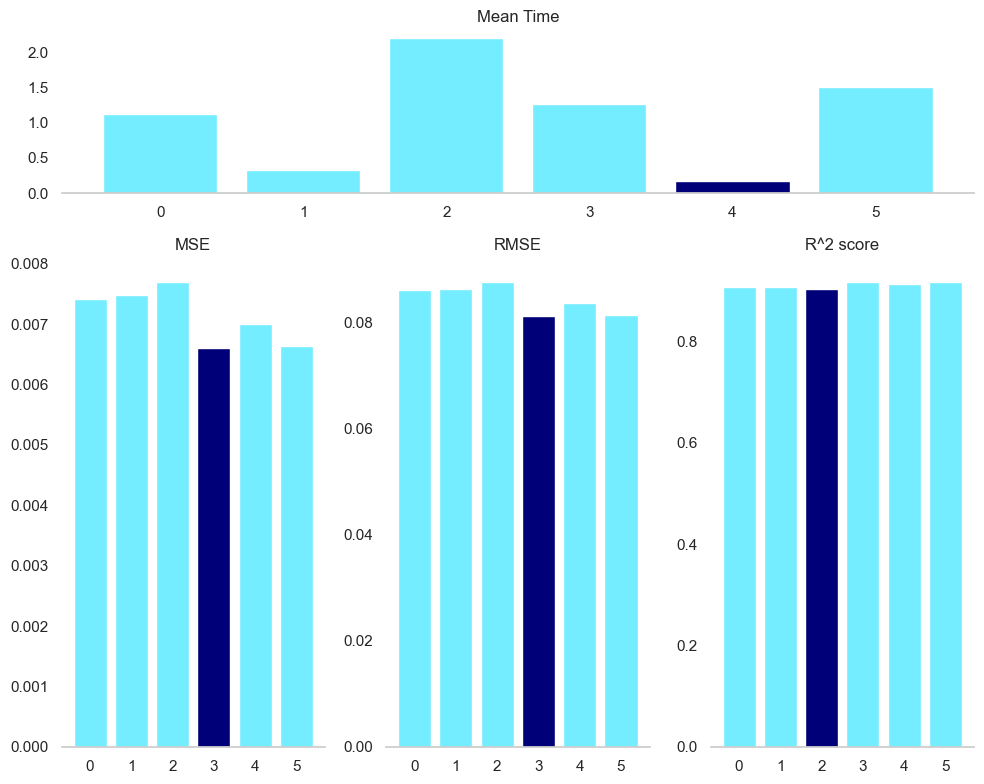

In [261]:
graph_struct = [{'r': 0, 'c':':'},
               {'r': 1, 'c':0},
               {'r': 1, 'c':1},
               {'r': 1, 'c':2}]

num_models = len(rasberry_returns['Mean Time'])

# Crear la figura y los subplots con gridspec
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 3])

for i, (k, v) in enumerate(rasberry_returns.items()):
    
    bars_colors = [l_blue for _ in range(len(v))]
    
    max_index = v.index(np.max(v))
    min_index = v.index(np.min(v))

    if k != 'R2 Score':
        bars_colors[min_index] = d_blue
    else:
        bars_colors[max_index] = d_blue
    
        
    title = k
    if (k == 'Time Test') or (k == 'Time Prediction'):
        title += ' (seg)'  
    if k == 'Model Size':
        title += ' (bytes)'
        
    r = graph_struct[i]['r']
    c = graph_struct[i]['c']
    
    if r in (0, 2):
        ax = plt.subplot(gs[r, :])
    else:
        ax = plt.subplot(gs[r, c])
        
        
    plt.bar(range(num_models), v, color=bars_colors)
    ax.set_title(title)
    ax.set_xticks(range(num_models))
    hide_frames(ax)

    # Eliminar la malla
    ax.grid(False)

height = 0.95

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()

# Mostrar las gráficas
plt.show()